# Assignment 3: Speech Emotion Recognition

## Content
1. [Download the Dataset and Understand the Format](#1)
    * [Load Crema Dataset](#2)
    * [Plotting each class](#3)
    * [Listen to each class](#4)
2. [Feature Extraction](#5)
3. [Split the dataset](#6)
4. [Different Models](#7)
    * [Time Model 1](#8)
    * [Frequency Domain 1 ](#9)
5. [Training and Evaluating](#10)
    * [Time Model 1](#11)
    * [Frequency Domain 1 ](#12)

### Including Libraries

In [1]:
import numpy as np
import pandas as pd 
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import IPython
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import os
import math
from sklearn import preprocessing
%pip install alive_progress
from alive_progress import alive_bar
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset , DataLoader
import gc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 745.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 30.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210079 sha256=18e191e9fafef2e017ca44f5a26944f2761be3ba2e1bf0185171e5707eb177f7
  Stored in directory: /root/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a79b0bef8bbe897a54aebfc757
Successfully built grapheme


### Specify dataset path

In [2]:
# If you are using google colab, set drive to True and set the path to the zip file
# if no, set drive to False and set the path to the folder
Crema_Path = '../Crema/'

drive = True
if drive:
    from google.colab import drive
    drive.mount('/content/drive')
    !unzip "/content/drive/My Drive/Pattern/Crema.zip" -d "/content/Crema/"
    Crema_Path='/content/Crema'

Streaming output truncated to the last 5000 lines.
  inflating: /content/Crema/1031_DFA_DIS_XX.wav  
  inflating: /content/Crema/1031_DFA_FEA_XX.wav  
  inflating: /content/Crema/1031_DFA_HAP_XX.wav  
  inflating: /content/Crema/1031_DFA_NEU_XX.wav  
  inflating: /content/Crema/1031_DFA_SAD_XX.wav  
  inflating: /content/Crema/1031_IEO_ANG_HI.wav  
  inflating: /content/Crema/1031_IEO_ANG_LO.wav  
  inflating: /content/Crema/1031_IEO_ANG_MD.wav  
  inflating: /content/Crema/1031_IEO_DIS_HI.wav  
  inflating: /content/Crema/1031_IEO_DIS_LO.wav  
  inflating: /content/Crema/1031_IEO_DIS_MD.wav  
  inflating: /content/Crema/1031_IEO_FEA_HI.wav  
  inflating: /content/Crema/1031_IEO_FEA_LO.wav  
  inflating: /content/Crema/1031_IEO_FEA_MD.wav  
  inflating: /content/Crema/1031_IEO_HAP_HI.wav  
  inflating: /content/Crema/1031_IEO_HAP_LO.wav  
  inflating: /content/Crema/1031_IEO_HAP_MD.wav  
  inflating: /content/Crema/1031_IEO_NEU_XX.wav  
  inflating: /content/Crema/1031_IEO_SAD_HI.wav  

### Choose which device to train

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

cuda


<a id="1"></a>
# Download the Dataset and Understand the Format 

<a id="2"></a>
## Load Crema Dataset

In [4]:
crema=[]
for wav in os.listdir(Crema_Path):
    emotion=wav.partition(".wav")[0].split('_')
    if emotion[2]=='SAD':
        crema.append(('sad',Crema_Path+'/'+wav))
    elif emotion[2]=='ANG':
        crema.append(('angry',Crema_Path+'/'+wav))
    elif emotion[2]=='DIS':
        crema.append(('disgust',Crema_Path+'/'+wav))
    elif emotion[2]=='FEA':
        crema.append(('fear',Crema_Path+'/'+wav))
    elif emotion[2]=='HAP':
        crema.append(('happy',Crema_Path+'/'+wav))
    elif emotion[2]=='NEU':
        crema.append(('neutral',Crema_Path+'/'+wav))
    else:
        crema.append(('unknown',Crema_Path+'/'+wav))
Crema_df=pd.DataFrame.from_dict(crema)
Crema_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
Crema_df.head()

,Emotion,File_Path
0,neutral,/content/Crema/1075_IEO_NEU_XX.wav
1,happy,/content/Crema/1027_IOM_HAP_XX.wav
2,fear,/content/Crema/1022_WSI_FEA_XX.wav
3,angry,/content/Crema/1086_IEO_ANG_MD.wav
4,disgust,/content/Crema/1051_TAI_DIS_XX.wav


In [5]:
emotion_colors = {'disgust':'blue','happy':'green','sad':'black','neutral':'aqua','fear':'purple','angry':'red','surprise':'yellow'}
emotion_names=Crema_df['Emotion'].unique()
emotion_names

array(['neutral', 'happy', 'fear', 'angry', 'disgust', 'sad'],
      dtype=object)

In [6]:
def wave_plot(data,sr,emotion,color):
    plt.figure(figsize=(7,4))
    plt.title(f'{emotion} emotion for waveplot',size=17)
    plt.plot(data, color=color)
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()


<a id="3"></a>
## Plotting each class

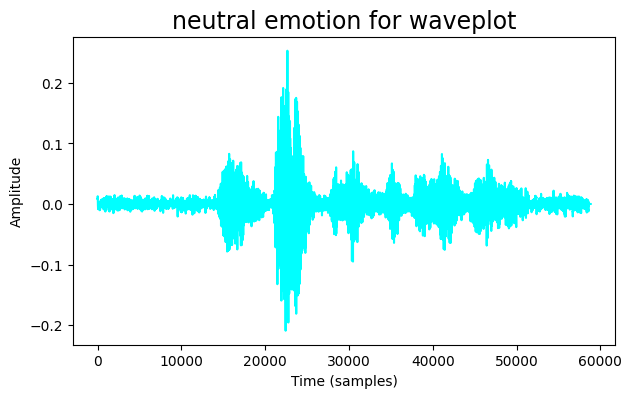

-------------------------------------------------------------


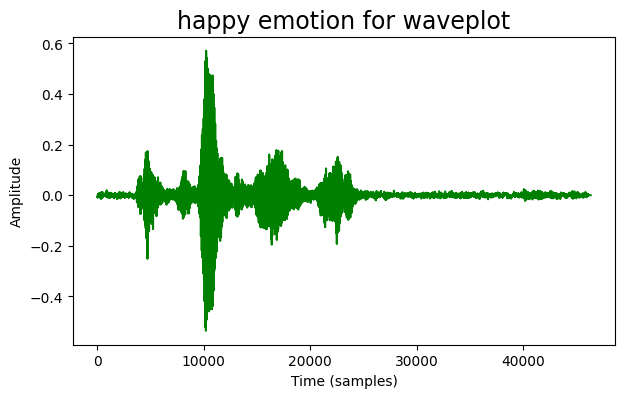

-------------------------------------------------------------


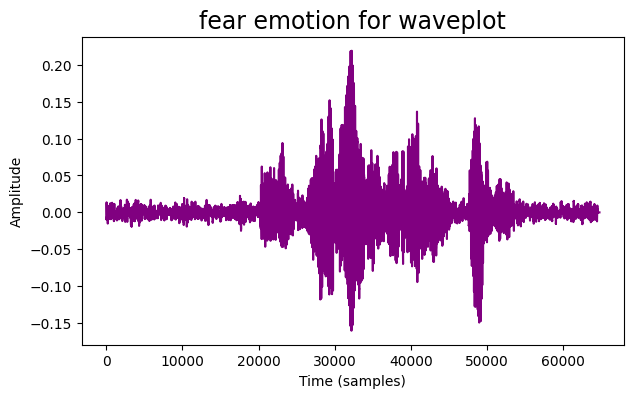

-------------------------------------------------------------


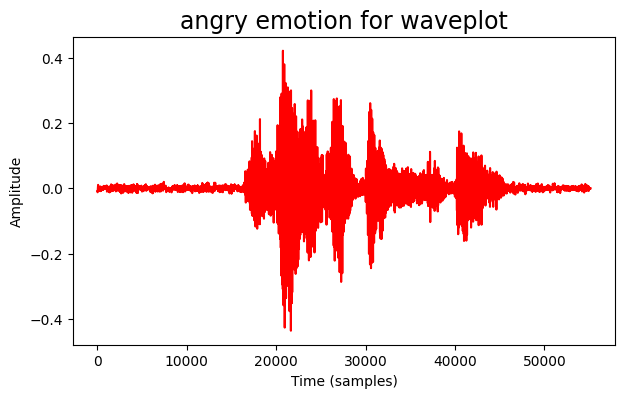

-------------------------------------------------------------


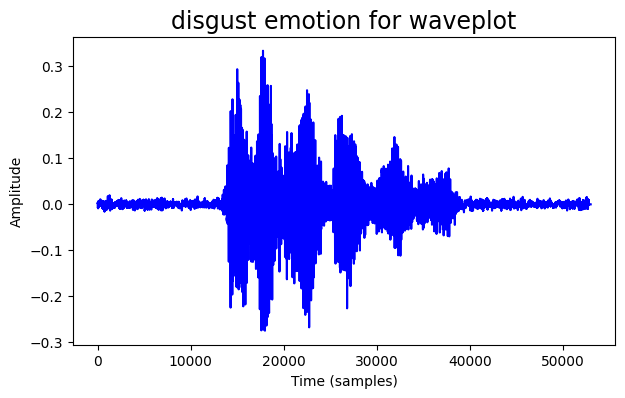

-------------------------------------------------------------


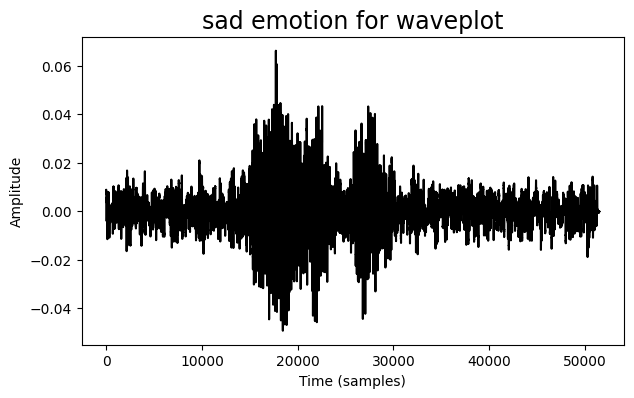

-------------------------------------------------------------


In [7]:
paths = []
for emotion in emotion_names:
    path=np.array(Crema_df['File_Path'][Crema_df['Emotion']==emotion])[11]
    data,sr=librosa.load(path)
    wave_plot(data,sr,emotion,emotion_colors[emotion])
    IPython.display.Audio(path)
    print("-------------------------------------------------------------")
    paths.append(path)


<a id="4"></a>
## Listen to each class

In [8]:
print("Sound of emotion: ",emotion_names[0])
IPython.display.Audio(paths[0])

Sound of emotion:  neutral


In [9]:
print("Sound of emotion: ",emotion_names[1])
IPython.display.Audio(paths[1])

Sound of emotion:  happy


In [10]:
print("Sound of emotion: ",emotion_names[2])
IPython.display.Audio(paths[2])

Sound of emotion:  fear


In [11]:
print("Sound of emotion: ",emotion_names[3])
IPython.display.Audio(paths[3])

Sound of emotion:  angry


In [12]:
print("Sound of emotion: ",emotion_names[4])
IPython.display.Audio(paths[4])

Sound of emotion:  disgust


In [13]:
print("Sound of emotion: ",emotion_names[5])
IPython.display.Audio(paths[5])

Sound of emotion:  sad


<a id="5"></a>
## Feature Extraction

In [14]:
def zero_crossing_rate(y, frame_length=2048, hope_length=512):
 # return librosa.feature.zero_crossing_rate(y=y, frame_length=frame_length, hop_length=hope_length).flatten()
  return np.mean(librosa.feature.zero_crossing_rate(y=y, frame_length=frame_length, hop_length=hope_length).T,axis=0)

def energy(y, frame_length=2048, hope_length=512):
  energy = []
  for hope in range(0, y.shape[0], hope_length):
    energy.append(np.sum(np.power(y[hope:hope+frame_length], 2)))

  energy = np.array(energy)
  return energy/frame_length

# amplitude envelope
def amplitude_envelope(y, frame_length=2048, hope_length=512):
  amplitude_envelope = []
  for hope in range(0, y.shape[0], hope_length):
    amplitude_envelope.append(np.max(np.abs(y[hope:hope+frame_length])))

  amplitude_envelope = np.array(amplitude_envelope)
  return amplitude_envelope

def mel_specto(y, sr):
  return librosa.feature.melspectrogram(y=y, sr=sr)


In [16]:
def get_features_time1(path,duration = 2.2 , offset = 0.2):
  
  y, sr = librosa.load(path= path , duration=duration , offset = offset)
  
  # stretch audio
  if len(y) < math.floor(duration *sr):
    temp_ar = np.zeros(int(math.floor(duration *sr) - len(y)))
    y = np.concatenate((y,temp_ar))

  features_time = np.hstack((
      y,
      zero_crossing_rate(y),
      energy(y)
      # amplitude_envelope(y)
      ))
  
  del(y)
  del(sr)
  
  return features_time


def get_features_time2(path,duration = 2.2 , offset = 0.2):
  
  y, sr = librosa.load(path= path , duration=duration , offset = offset)
  
  # stretch audio
  if len(y) < math.floor(duration *sr):
    temp_ar = np.zeros(int(math.floor(duration *sr) - len(y)))
    y = np.concatenate((y,temp_ar))

  features_time = np.hstack((
      y,
      zero_crossing_rate(y),
      energy(y),
      amplitude_envelope(y)
      ))
  
  del(y)
  del(sr)
  
  return features_time

def get_features_freq(path,duration = 2.2 , offset = 0.2):
  
  y, sr = librosa.load(path= path , duration=duration , offset = offset)
  
  # stretch audio
  if len(y) < math.floor(duration *sr):
    temp_ar = np.zeros(int(math.floor(duration *sr) - len(y)))
    y = np.concatenate((y,temp_ar))

  
  features_spect = mel_specto(y, sr)
  del(y)
  del(sr)
  
  return features_spect

In [17]:
def load_data(df):
    X_time,X_spect, y = [], [], []

    print('loading')
    for path,emotion,index in zip(Crema_df.File_Path,Crema_df.Emotion,range(df.File_Path.shape[0])):
        time_features1 = get_features_time1(path)
        freq_features = get_features_freq(path)
        X_time.append(time_features1)
        X_spect.append(freq_features)
        y.append(emotion)
        del(time_features1)
        del(freq_features)
        
    print('Done')
    return X_time,X_spect, y

In [18]:
features_time,features_spect, labels = load_data(Crema_df)

loading
Done


<a id="6"></a>
## Split the dataset

In [19]:
# splitting  dataset to 70% trian and validation and 30% test
x_train_time, x_test_time, y_train_time, y_test_time = train_test_split(features_time, labels,test_size=0.3, stratify = labels, random_state=42 )

# splitting train set to 95% trian and 5% validation
x_train_time, x_val_time, y_train_time, y_val_time = train_test_split(x_train_time, y_train_time,test_size=0.05, stratify =y_train_time , random_state=42)

In [20]:
np.array(x_train_time).shape

(4948, 48606)

In [21]:
# Label encoding

label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'Emotion'. 

y_train_time= label_encoder.fit_transform(y_train_time) 
y_val_time = label_encoder.transform(y_val_time) 
y_test_time = label_encoder.transform(y_test_time) 

In [22]:
scaler = preprocessing.StandardScaler()
x_train_time = scaler.fit_transform(x_train_time)
x_test_time = scaler.transform(x_test_time)
x_val_time = scaler.transform(x_val_time)

In [23]:
x_train_time = np.array(x_train_time ).reshape(len(x_train_time),1,-1)
x_val_time = np.array(x_val_time).reshape(len(x_val_time),1,-1)
x_test_time = np.array(x_test_time).reshape(len(x_test_time),1,-1)

In [24]:
x_train_time.shape


(4948, 1, 48606)

In [25]:
# splitting  dataset to 70% trian and validation and 30% test

x_train_freq, x_test_freq, y_train_freq, y_test_freq = train_test_split(features_spect, labels,test_size=0.3, stratify = labels, random_state=42)

# splitting train set to 95% trian and 5% validation
x_train_freq, x_val_freq, y_train_freq, y_val_freq = train_test_split(x_train_freq, y_train_freq,test_size=0.05, stratify =y_train_freq , random_state=42)

In [26]:
np.array(x_test_freq).shape


(2233, 128, 95)

In [27]:
# Label encoding

label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'Emotion'. 

y_train_freq= label_encoder.fit_transform(y_train_freq) 
y_val_freq = label_encoder.transform(y_val_freq) 
y_test_freq = label_encoder.transform(y_test_freq) 

In [28]:
class MyDataset(Dataset):
  def __init__(self , array , labels):
        self.array = array
        self.labels = labels

  def __getitem__(self,index):
    audio_features = self.array[index]
    return torch.tensor(audio_features).float() , torch.tensor(int(self.labels[index]))

  def __len__(self):
    return len(self.array)

<a id="7"></a>
## Different Models

<a id="8"></a>
### Time Model 1

In [29]:
class Model(nn.Module):
  def __init__(self):
    super(Model , self).__init__()
    self.conv1 = nn.Conv1d(in_channels=1 , out_channels=512 , kernel_size=5 , stride=1)
    self.bn1 = nn.BatchNorm1d(512)
    self.conv2 = nn.Conv1d(in_channels=512 , out_channels=512 ,kernel_size=5 , stride=1)
    self.bn2 = nn.BatchNorm1d(512)
    
    self.conv3 = nn.Conv1d(in_channels=512 , out_channels=256 , kernel_size=5 , stride=1)
    self.bn3 = nn.BatchNorm1d(256)    
    
    self.conv4 = nn.Conv1d(in_channels=256 , out_channels=256 , kernel_size=5 , stride=1)
    self.bn4 = nn.BatchNorm1d(256)
    
    
    self.conv5 = nn.Conv1d(in_channels=256 , out_channels=128 , kernel_size=5 , stride=1)
    self.bn5 = nn.BatchNorm1d(128)

    # fully connected layers
    self.fc1 = nn.Linear(in_features=193536 , out_features=256)
    self.fc2 = nn.Linear(in_features=256 , out_features=128)
        
    self.fc3 = nn.Linear(in_features=128 , out_features=6)

  def forward(self,x):

    x = self.conv1(x)


    x = F.relu(self.bn1(x))
    x = F.max_pool1d(x,5,2)
    x = self.conv2(x)
    x = F.relu(self.bn2(x))
    x = F.max_pool1d(x,5,2)
    x = self.conv3(x)
    x = F.relu(self.bn3(x))
    x = F.max_pool1d(x,5,2)
    x = self.conv4(x)
    x = F.relu(self.bn4(x))    
    x = F.max_pool1d(x,5,2)
    x = self.conv5(x)
    x = F.relu(self.bn5(x))
    x = F.max_pool1d(x,5,2)
    

    x = torch.flatten(x,1)
    
    x = self.fc1(x)
    x = F.relu(x)

    x = self.fc2(x)

    x = F.relu(x)
    
    x = self.fc3(x)
    output = F.log_softmax(x , dim=1)

    return output

<a id="8"></a>
### Freq Model 1

In [30]:
class FreqModel(nn.Module):
  def __init__(self):
    super(FreqModel , self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1 , out_channels=512 , kernel_size=5 , stride=1)
    self.bn1 = nn.BatchNorm2d(512)
    self.conv2 = nn.Conv2d(in_channels=512 , out_channels=512 , kernel_size=5 , stride=1)
    self.bn2 = nn.BatchNorm2d(512)
    self.conv3 = nn.Conv2d(in_channels=512 , out_channels=128 , kernel_size=5 , stride=1)
    self.bn3 = nn.BatchNorm2d(128)

    # fully connected layers
    self.fc1 = nn.Linear(in_features=5760 , out_features=256)
    self.fc2 = nn.Linear(in_features=256 , out_features=6)

  def forward(self,x):
    gc.collect()
    torch.cuda.empty_cache()
    x = self.conv1(x)

    x = F.relu(self.bn1(x))
    x = F.max_pool2d(x,5,2)

    x = self.conv2(x)
    x = F.relu(self.bn2(x))
    x = F.max_pool2d(x,5,2)

    x = self.conv3(x)
    x = F.relu(self.bn3(x))
    x = F.max_pool2d(x,5,2)
    x = torch.flatten(x,1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    output = F.log_softmax(x , dim=1)
    return output

### Helper Functions for training and testing 

In [31]:
def trainModel(model , dataloader , optimizer,current_epoch , loss_vec , acc_vec):
  
  model.train()

  loss_fun = nn.CrossEntropyLoss()
  total_loss = 0
  num_correct = 0

  with alive_bar(len(dataloader), force_tty=True) as bar:
    for batch_idx , (data , label) in enumerate(dataloader):
      data = data.to(device)
      label = label.to(device)

      optimizer.zero_grad()
      output = model(data)
      
      loss = loss_fun(output, label)
     
      total_loss +=  loss.item()
      loss.backward()
      optimizer.step()
      

      pred = torch.argmax(output, 1)
      num_correct +=  pred.eq(label.data).cpu().sum()
      bar()

    acc = 100 * num_correct.to(torch.float32) / len(dataloader.dataset)
    acc_vec.append(float(acc))
    loss_vec.append(float(total_loss/len(dataloader)))
    
    print('Train Epoch : {} |  | loss = {}  train acc. = {}'.format(current_epoch , total_loss/len(dataloader) , acc))
    

In [32]:
def validateModel(model , dataloader , loss_vector,acc_vector):
  
  model.eval()

  loss_fun = nn.CrossEntropyLoss()
  total_loss = 0
  num_correct = 0
  with torch.no_grad():
    for (data , label) in dataloader:
      
      data = data.to(device)
      label = label.to(device)
      
      output = model(data)
      
      loss = loss_fun(output, label)
    
      total_loss = total_loss + loss.data.item()
      pred = torch.argmax(output, 1)
      num_correct +=  pred.eq(label.data).cpu().sum()
   
  
  val_loss = total_loss / len(dataloader)
  loss_vector.append(val_loss)

  acc = 100 * num_correct.to(torch.float32) / len(dataloader.dataset)
  acc_vector.append(float(acc))

  print('Validation set Average loss : {}  , Acc. : | {} / {} | with {} %'.format(val_loss, num_correct, len(dataloader.dataset), acc ))

In [33]:
def testModel(model , dataloader):
  
  model.eval()
  pred_vec , labels_vec = [] , []  

  num_correct = 0
  with torch.no_grad():
    for (data , label) in dataloader:
      gc.collect()
      torch.cuda.empty_cache()
      
      data = data.to(device)
      label = label.to(device)
      
      output = model(data)

      pred = torch.argmax(output, 1)
      pred_vec += pred
      labels_vec+= label.data
      num_correct +=  pred.eq(label.data).cpu().sum()
        

  acc = 100 * num_correct.to(torch.float32) / len(dataloader.dataset)
  

  print('Test set Average Accuracy : | {} / {} | with {} %'.format(num_correct, len(dataloader.dataset), acc ))
  return labels_vec , pred

In [34]:
def saveModel(model , file_name):
    torch.save(model.state_dict() , file_name)
    
def loadModel(file_name , time_domain = True):
    checkpoint = torch.load(file_name)
    if time_domain:
        model = Model().to(device)
        model.load_state_dict(checkpoint)
    else : 
        model = FreqModel().to(device)
        model.load_state_dict(checkpoint)
    return model

In [35]:
def graphs_train_val_acc(train_acc,val_acc):
    plt.plot(val_acc, label='validation accuracy')
    plt.plot(train_acc, label='train accuracy')
    plt.title('Training history')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

In [36]:
def graphs_train_val_loss(train_loss , val_loss):
    plt.plot(val_loss, label='validation Loss')
    plt.plot(train_loss, label='train Loss')
    plt.title('Training history')
    plt.ylabel('Accuracy Loss')
    plt.xlabel('Epoch')
    plt.legend()

In [37]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

<a id="9"></a>
## Training and Evaluating

<a id="10"></a>
### Training and Evaluating Time model 1

In [38]:
train_dataset = MyDataset(x_train_time , y_train_time)
validation_dataset = MyDataset(x_val_time , y_val_time)
test_dataset = MyDataset(x_test_time , y_test_time)

In [43]:
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset , batch_size = BATCH_SIZE ,shuffle = True )
validation_loader = DataLoader(validation_dataset , batch_size = BATCH_SIZE ,shuffle = True )
test_loader = DataLoader(test_dataset , batch_size = BATCH_SIZE ,shuffle = True )

In [46]:
# del(model)
# del(optimizer)
# del(sheduler)
gc.collect()
torch.cuda.empty_cache()
model = Model().to(device)
EPOCHS = 25
learning_rate = 0.001
weight_decay=0.0001
optimizer = torch.optim.Adam(model.parameters() , learning_rate , weight_decay=weight_decay)
sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer , patience=3 , threshold=1e-4)

In [47]:
val_loss_vec1 , val_acc_vec1 = [] , []
train_loss_vec1 , train_acc_vec1 = [] , []
lr_vec = []
earlyStoppingPatience = 3
earlyStoppingCounter = 0
for e in range(EPOCHS):
  print('--- Start Epoch Number : {} ----'.format(e+1))
  gc.collect()
  torch.cuda.empty_cache()
  lr_vec.append(get_lr(optimizer))
  
  trainModel(model , train_loader , optimizer , e+1 , train_loss_vec1  ,train_acc_vec1)
  gc.collect()
  torch.cuda.empty_cache()

  validateModel(model , validation_loader , val_loss_vec1  ,val_acc_vec1 )
  sheduler.step(val_loss_vec1[e])
  saveModel(model , 'time_domain1_checkpoint_{}.pth'.format(e))
   
  # early stopping
  cur_loss = val_loss_vec1[-1]
  last_loss = val_loss_vec1[-2]
  if cur_loss < last_loss:
    earlyStoppingCounter += 1


  if earlyStoppingCounter > earlyStoppingPatience:
      print("Early stopping at epoch:", e)
      break
  

--- Start Epoch Number : 1 ----
on 310: Train Epoch : 1 |  | loss = 2.4573187958809637  train acc. = 29.4260311126709
|████████████████████████████████████████| 310/310 [100%] in 7:02.2 (0.73/s)    
Validation set Average loss : 1.6543849846896004  , Acc. : | 101 / 261 | with 38.69731903076172 %
--- Start Epoch Number : 2 ----
on 310: Train Epoch : 2 |  | loss = 1.586182338191617  train acc. = 34.03395462036133
|████████████████████████████████████████| 310/310 [100%] in 7:03.6 (0.73/s)    
Validation set Average loss : 1.4131879876641666  , Acc. : | 111 / 261 | with 42.52873611450195 %
--- Start Epoch Number : 3 ----
on 310: Train Epoch : 3 |  | loss = 1.5227274998541802  train acc. = 36.56022644042969
|████████████████████████████████████████| 310/310 [100%] in 7:03.9 (0.73/s)    
Validation set Average loss : 1.6143595751594095  , Acc. : | 106 / 261 | with 40.6130256652832 %
--- Start Epoch Number : 4 ----
on 310: Train Epoch : 4 |  | loss = 1.5293382998435727  train acc. = 37.36863

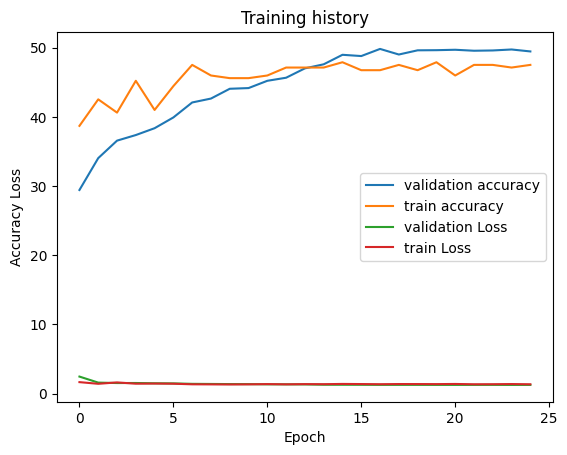

In [48]:
graphs_train_val_acc(val_acc_vec1,train_acc_vec1)
graphs_train_val_loss(val_loss_vec1 ,train_loss_vec1)

In [1]:
y_true , y_pred = testModel(model , test_loader)

acc_time = accuracy_score(y_true, y_pred)
f_score_time = f1_score(y_true, y_pred)
matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = emotion_names, yticklabels = emotion_names)


NameError: ignored

In [ ]:
del(model)
del(optimizer)
del(sheduler)
del(train_dataset,validation_dataset,test_dataset)

<a id="11"></a>
### Training and Evaluating Freq model 2

In [ ]:
n = len(x_train_freq[0])
m = len(x_train_freq[0][0])
for i in range(len(x_train_freq)):
  x_train_freq[i] = x_train_freq[i].reshape(1 , n ,m)
  

for i in range(len(x_val_freq)):
  x_val_freq[i] = x_val_freq[i].reshape(1 , n ,m)

for i in range(len(x_test_freq)):
  x_test_freq[i] = x_test_freq[i].reshape(1 , n ,m)

In [ ]:
np.array(x_train_freq).shape


In [ ]:
train_dataset = MyDataset(x_train_freq , y_train_freq)
validation_dataset = MyDataset(x_val_freq , y_val_freq)
test_dataset = MyDataset(x_test_freq , y_test_freq)

In [ ]:
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset , batch_size = BATCH_SIZE ,shuffle = True )
validation_loader = DataLoader(validation_dataset , batch_size = BATCH_SIZE ,shuffle = True )
test_loader = DataLoader(test_dataset , batch_size = BATCH_SIZE ,shuffle = True )

In [ ]:
model_freq = FreqModel().to(device)
EPOCHS = 25
learning_rate = 0.001
weight_decay=0.0001
optimizer = torch.optim.Adam(model_freq.parameters() , learning_rate , weight_decay=weight_decay)
sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer , patience=3 , threshold=1e-4)

In [ ]:
val_loss_vec2 , val_acc_vec2 = [] , []
train_loss_vec2 , train_acc_vec2 = [] , []
for e in range(EPOCHS):
  print('--- Start Epoch Number : {} ----'.format(e+1))
  gc.collect()
  torch.cuda.empty_cache()
  
  trainModel(model_freq , train_loader , optimizer , e+1 , train_loss_vec2 ,train_acc_vec2 )
  gc.collect()
  torch.cuda.empty_cache()

  validateModel(model_freq , validation_loader , val_loss_vec2  ,val_acc_vec2 )
  sheduler.step(val_loss_vec2[e])
  saveModel(model , 'freq_domain1_checkpoint_{}.pth'.format(e))

In [ ]:
graphs_train_val_acc(val_acc_vec2,train_acc_vec2)
graphs_train_val_loss(val_loss_vec2 ,train_loss_vec2)

In [ ]:
y_true , y_pred = testModel(model , test_loader)

acc_time = accuracy_score(y_true, y_pred)
f_score_time = f1_score(y_true, y_pred)
matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = emotion_names, yticklabels = emotion_names)